In [ ]:
#Import required libraries
import os
import shutil
import zipfile
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
#Allocating locations for dataset
drive.mount('/content/drive')
drive_dataset = '/content/drive/My Drive/plant_disease_project/data/raw/PlantVillage.zip'
local_zip_dataset = '/content/PlantVillage.zip'
local_dataset = '/content/dataset'

Mounted at /content/drive


In [ ]:
#Download and extract dataset, if it doesn't exist
if not os.path.exists(local_dataset):
  shutil.copy(drive_dataset, local_zip_dataset)
  with zipfile.ZipFile(local_zip_dataset, 'r') as zip_ref:
    zip_ref.extractall(local_dataset)
  os.remove(local_zip_dataset)
else:
  print("Dataset is already loaded.")

In [ ]:
#Check if dataset is located correctly
print(f"Checking inside {local_dataset}")
try:
  nested_folder = 'plantvillage dataset'
  contents = os.path.join(local_dataset, nested_folder)
  folder_list = os.listdir(contents)
  print(f"There are {len(folder_list)} items.")
  print(f"The {len(folder_list)} items: ", folder_list[:3])
except FileNotFoundError:
  print("Directory not found.")

Checking inside /content/dataset
There are 3 items.
The 3 items:  ['segmented', 'color', 'grayscale']


In [ ]:
#Set parameters
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)
SEED = 123
base_dir = '/content/dataset/plantvillage dataset'

def load_subset(folder_name, subset_type):
    return tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_dir, folder_name),
        validation_split=0.2,
        subset=subset_type,
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        verbose=1
    )

train_color = load_subset('color', 'training')
train_gray = load_subset('grayscale', 'training')
train_seg = load_subset('segmented', 'training')

val_color = load_subset('color', 'validation')
val_gray = load_subset('grayscale', 'validation')
val_seg = load_subset('segmented', 'validation')

train_ds = tf.data.Dataset.sample_from_datasets(
    [train_color, train_gray, train_seg], weights=[1/3, 1/3, 1/3], seed=SEED
)
val_ds = tf.data.Dataset.sample_from_datasets(
    [val_color, val_gray, val_seg], weights=[1/3, 1/3, 1/3], seed=SEED
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

class_names = train_color.class_names
print(f"Classes Detected: {len(class_names)}")

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54306 files belonging to 38 classes.
Using 43445 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Found 54306 files belonging to 38 classes.
Using 10861 files for validation.
Classes Detected: 38


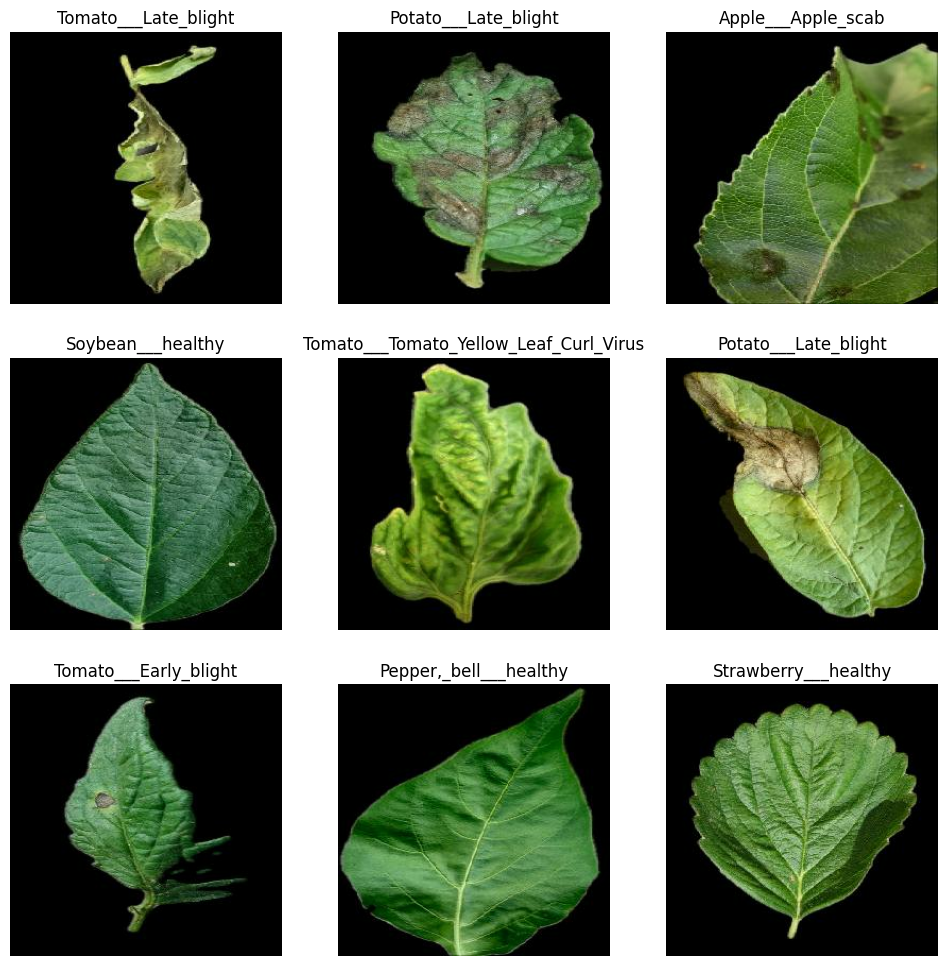

In [ ]:
#Before training, check for random images and their labels, for 'sanity' check
plt.figure(figsize = (12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_id = labels[i]
    class_name = class_names[label_id]
    plt.title(class_name)
    plt.axis("off")

In [ ]:
#Build Model
input_shape = (256, 256, 3)
n_classes = len(class_names)

model = models.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1.0/255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification Head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Set location for Checkpoints for model and set early stopping
checkpoint_dir = '/content/drive/My Drive/plant_disease_project/models/checkpoints'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
  print(f"Created directory: {checkpoint_dir}")
callbacks = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath = os.path.join(checkpoint_dir, 'universal_model.keras'),
          save_best_only = True,
          monitor = 'val_accuracy',
          mode = 'max',
          verbose = 1
      ),
      tf.keras.callbacks.EarlyStopping(
          monitor = 'val_loss',
          patience = 5,
          restore_best_weights = True
      )
  ]

In [ ]:
#Start Training
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50
   8147/Unknown 306s 36ms/step - accuracy: 0.3227 - loss: 2.4647

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.68972, saving model to /content/drive/My Drive/plant_disease_project/models/checkpoints/universal_model.keras
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 335s 40ms/step - accuracy: 0.3227 - loss: 2.4645 - val_accuracy: 0.6897 - val_loss: 0.9920
Epoch 2/50
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7149 - loss: 0.9138
Epoch 2: val_accuracy improved from 0.68972 to 0.77473, saving model to /content/drive/My Drive/plant_disease_project/models/checkpoints/universal_model.keras
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 329s 40ms/step - accuracy: 0.7149 - loss: 0.9138 - val_accuracy: 0.7747 - val_loss: 0.6985
Epoch 3/50
8147/8148 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7820 - loss: 0.6885
Epoch 3: val_accuracy improved from 0.77473 to 0.79781, saving model to /content/drive/My Drive/plant_disease_project/models/checkpoints/universal_model.keras
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 326s 40ms/step - accuracy: 0.7820 - loss: 0.6885 - val_accuracy: 0.7978 

In [11]:
#For diseases, accuracy of 80-85% is not good, so we slow down the learning rate to improve learning
import os
import tensorflow as tf

checkpoint_path = '/content/drive/My Drive/plant_disease_project/models/checkpoints/universal_model.keras'

print("Loading saved model from Google Drive.")
model = tf.keras.models.load_model(checkpoint_path)
print("Model loaded successfully!")

model.evaluate(val_ds)

#Compile again

print("Slowing down learning rate to find the 'fine details'.")

# 1. Re-compile with a MUCH slower learning rate (0.0001 instead of 0.001)
# This allows the model to make tiny adjustments without overshooting.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 2. Continue Training for another 10-20 epochs
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Loading saved model from Google Drive.
Model loaded successfully!
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.8312 - loss: 0.5573
Slowing down learning rate to find the 'fine details'.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


   8148/Unknown 313s 38ms/step - accuracy: 0.8732 - loss: 0.3938
Epoch 1: val_accuracy improved from -inf to 0.82930, saving model to /content/drive/My Drive/plant_disease_project/models/checkpoints/universal_model.keras
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 342s 41ms/step - accuracy: 0.8732 - loss: 0.3938 - val_accuracy: 0.8293 - val_loss: 0.6000
Epoch 2/20
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8880 - loss: 0.3452
Epoch 2: val_accuracy did not improve from 0.82930
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 338s 41ms/step - accuracy: 0.8880 - loss: 0.3452 - val_accuracy: 0.8260 - val_loss: 0.6205
Epoch 3/20
8147/8148 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8939 - loss: 0.3294
Epoch 3: val_accuracy improved from 0.82930 to 0.83826, saving model to /content/drive/My Drive/plant_disease_project/models/checkpoints/universal_model.keras
8148/8148 ━━━━━━━━━━━━━━━━━━━━ 339s 42ms/step - accuracy: 0.8939 - loss: 0.3294 - val_accuracy: 0.8383 - val_loss: 0.5879
Epoch 4/20
8148/8148 ━━━━

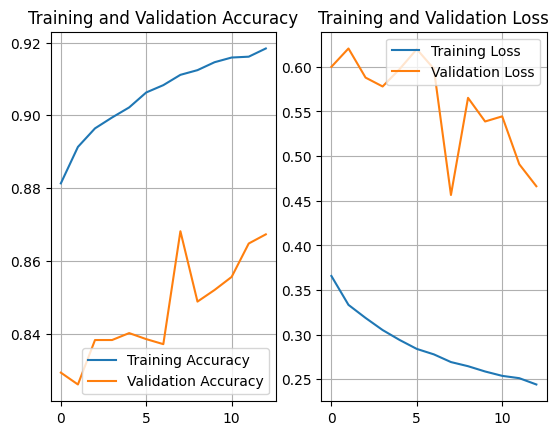

In [13]:
#Plot graph of accuracies and loss
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs_range = range(len(acc))
#Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)
#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
#Display
plt.show()